imports

טעינת האקסל והפרדת התפקיד האחרון של הבן אדם להיות הLabel

In [1]:
# ==============================
# FULL END-TO-END CODE IN ONE CELL (COLAB)
# ==============================
# Key Adjustments:
# 1) In "build_text_for_embedding", we handle None in leftover_positions by converting them to empty strings or skipping them.
# 2) Everything else remains the same.

!pip install -q transformers torch scikit-learn pandas tensorflow

import os
import re
import ast

import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from transformers import AutoTokenizer, AutoModel

##########################
# 1) LOAD CSV & CHECK
##########################
csv_path = 'resume_data.csv'  # <-- EDIT IF NEEDED
df = pd.read_csv(csv_path)
print("DataFrame shape:", df.shape)
print("Columns:", df.columns.tolist())

# We assume these columns exist: 'skills', 'major_field_of_studies', 'degree_names', 'positions'.
for req_col in ["skills", "major_field_of_studies", "degree_names", "positions"]:
    if req_col not in df.columns:
        raise ValueError(f"Column '{req_col}' missing from CSV. Please check your data.")

df["skills"]                 = df["skills"].fillna("")
df["major_field_of_studies"] = df["major_field_of_studies"].fillna("")
df["degree_names"]           = df["degree_names"].fillna("")
df["positions"]              = df["positions"].fillna("[]")

##########################
# 2) PARSE LABEL = FIRST POSITION
##########################
def parse_positions_and_label(pos_str):
    """
    Parse 'positions' as a Python list.
    Label = the FIRST item, leftover = everything else.
    """
    try:
        pos_list = ast.literal_eval(pos_str)
        if isinstance(pos_list, list) and len(pos_list) > 0:
            label = pos_list[0].strip() if pos_list[0] else ""
            leftover = pos_list[1:]  # everything after first
            return label, leftover
        else:
            return "", []
    except:
        return pos_str, []  # fallback if parse fails

df_labels = []
df_positions_for_embed = []
for p in df["positions"]:
    label, leftover = parse_positions_and_label(p)
    df_labels.append(label)
    df_positions_for_embed.append(leftover)

df["first_position_label"]   = df_labels
df["first_position_label"] = df["first_position_label"].str.strip().str.strip("'").str.lower()
df["positions_for_embedding"] = df_positions_for_embed



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.2 MB/s eta 0:00:00
DataFrame shape: (9544, 13)
Columns: ['skills', 'degree_names', 'passing_years', 'major_field_of_studies', 'start_dates', 'end_dates', 'related_skils_in_job', 'positions', 'job_position_name', 'educatio

פה אני מנקה את האקסל ומשאירה רק את הרשומות שבהן התפקיד האחרון שהבן אדם ביצע הוא מתוך הרשימה המצומצמת של תפקידי התכנות שהשארנו

In [2]:
import pandas as pd

# נתיב לקובץ ה-CSV
#csv_path = 'resume_data.csv'
#df = pd.read_csv(csv_path)

# נתיב לקובץ האקסל עם רשימת התפקידים המורשים
positions_path = 'positions.csv'
# נניח שקובץ האקסל כולל עמודה בשם 'role' המכילה את שמות התפקידים
allowed_positions_df = pd.read_csv(positions_path)
allowed_positions_df['position'] = allowed_positions_df['position'].str.strip().str.strip("'").str.lower()
allowed_positions = allowed_positions_df['position'].dropna().unique().tolist()

# סינון הרשומות: נשאיר רק את אלו שבהן התפקיד הראשון מופיע ברשימת התפקידים המורשים
df_cleaned = df[df['first_position_label'].isin(allowed_positions)]

# הצגת מספר הרשומות לפני ואחרי הסינון
print("מספר רשומות לפני הסינון:", df.shape[0])
print("מספר רשומות אחרי הסינון:", df_cleaned.shape[0])

# שמירת הנתונים המסוננים לקובץ CSV חדש
df_cleaned.to_csv('resume_data_cleaned.csv', index=False)
print("הקובץ החדש נשמר בשם 'resume_data_cleaned.csv'")

מספר רשומות לפני הסינון: 9544
מספר רשומות אחרי הסינון: 4180
הקובץ החדש נשמר בשם 'resume_data_cleaned.csv'


first_position_label
business development manager      276
engineering manager               196
engineering technician            196
machine learning engineer         140
engineering assistant             140
                                 ... 
developer engineer                 28
junior sde                         28
data programmer                    28
nlp analyst                        28
junior system engineer analyst     28
Name: count, Length: 93, dtype: int64


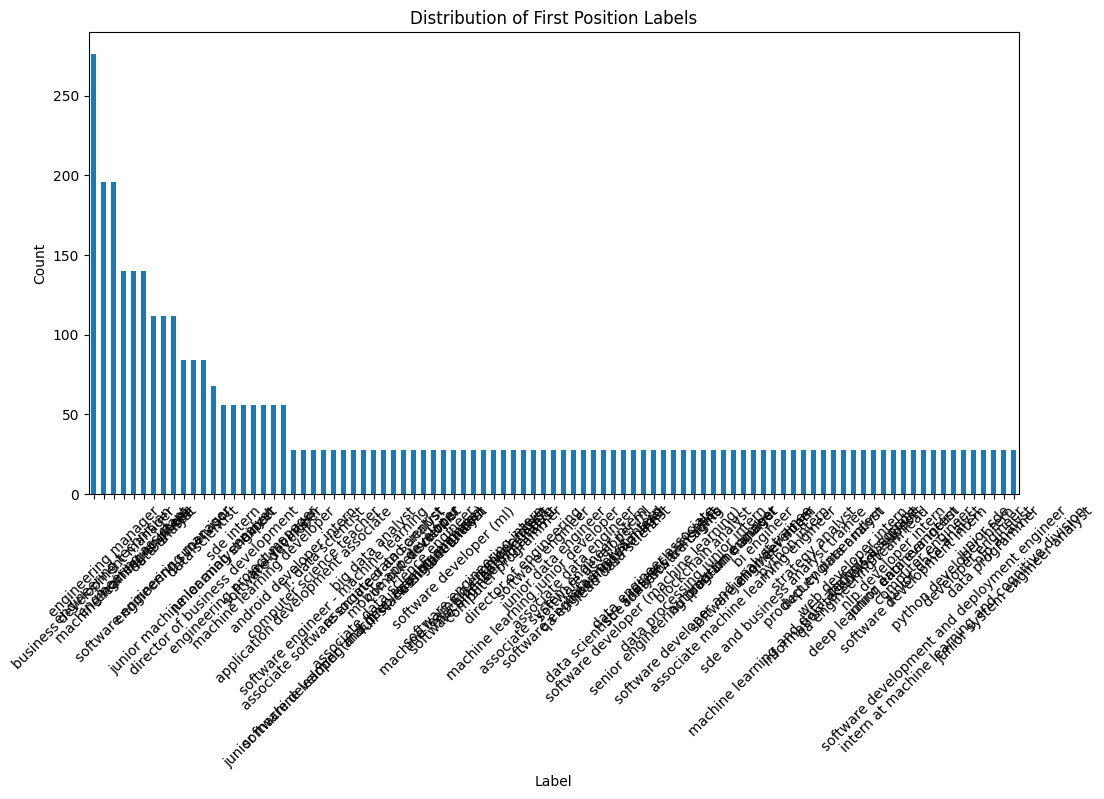

In [4]:
import matplotlib.pyplot as plt

# חשב את מספר ההופעות של כל תווית
label_counts = df_cleaned["first_position_label"].value_counts()
print(label_counts)

# יצירת תרשים עמודות
plt.figure(figsize=(12, 6))
label_counts.plot(kind="bar")
plt.title("Distribution of First Position Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [11]:
# Encode label
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_cleaned["first_position_label"].values)
num_classes = len(label_encoder.classes_)
print("Number of distinct first-position labels:", num_classes)

##########################
# 3) BUILD TEXT FOR BERT
##########################
def build_text_for_embedding(row):
    """
    We ONLY use columns: 'skills', 'major_field_of_studies',
    'degree_names', and leftover positions (skipping the first position which is our label).
    """
    text_parts = []

    # A) Skills might be "['Skill1','Skill2']"
    s = row["skills"]
    s_clean = re.sub(r"[\[\]']", "", s)  # remove brackets, quotes
    text_parts.append(s_clean.strip())

    # B) Major field
    m = row["major_field_of_studies"]
    text_parts.append(m.strip())

    # C) Degree names (again may have brackets)
    d = row["degree_names"]
    d_clean = re.sub(r"[\[\]']", "", d)
    text_parts.append(d_clean.strip())

    # D) leftover positions => row["positions_for_embedding"] is a list
    leftover_positions = row["positions_for_embedding"]
    if isinstance(leftover_positions, list):
        # Convert every element to a string, ignoring None
        leftover_positions_str = [str(x) for x in leftover_positions if x is not None]
        leftover_str = " ".join(leftover_positions_str)
        text_parts.append(leftover_str.strip())

    # Join all
    return " ".join(x for x in text_parts if x).strip()

##########################
# 4) BERT EMBEDDING FN
##########################
@torch.no_grad()
def get_bert_embedding(text, tokenizer, bert_model, device):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=128,
        padding="max_length"
    )
    for k, v in inputs.items():
        inputs[k] = v.to(device)

    outputs = bert_model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    emb = last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return emb

##########################
# 5) BUILD or LOAD X
##########################
X_filename = "X_embeddings.npy"
y_filename = "y_labels.npy"

if os.path.exists(X_filename) and os.path.exists(y_filename):
    print("\n=== Embeddings found. Loading them. ===")
    X = np.load(X_filename)
    y_loaded = np.load(y_filename)
    if len(y_loaded) == len(y):
        y = y_loaded
    else:
        print("WARNING: loaded y doesn't match current data. Using newly computed y.")
else:
    print("\n=== No saved embeddings found, computing with BERT... ===")
    model_name = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    bert_model = AutoModel.from_pretrained(model_name)
    bert_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bert_model.to(device)

    all_texts = df_cleaned.apply(build_text_for_embedding, axis=1)
    X_list = []
    for i, txt in enumerate(all_texts):
        emb = get_bert_embedding(txt, tokenizer, bert_model, device)
        X_list.append(emb)
        if (i+1) % 100 == 0:
            print(f"Embedded {i+1} rows...")
    X = np.vstack(X_list)
    print("Final embedding shape:", X.shape)
    X = X.astype(np.float32)

    # Save
    np.save(X_filename, X)
    np.save(y_filename, y)
    print(f"Embeddings saved as '{X_filename}' and '{y_filename}'.")

##########################
# 6) TRAIN MODEL
##########################
print("X shape:", X.shape)
print("y shape:", y.shape)

# חלוקה ראשונית: 70% לאימון, 30% לשאר (שיכלול גם validation וגם test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# חלוקה של ה-30% שנותרו ל-50/50 (כלומר 15% validation ו-15% test ביחס לנתונים המקוריים)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# המרת התוויות ל-one-hot encoding
y_train_oh = to_categorical(y_train, num_classes)
y_val_oh = to_categorical(y_val, num_classes)
y_test_oh = to_categorical(y_test, num_classes)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=3,  # adjust as needed
    batch_size=32,
    verbose=1
)


test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

##########################
# 7) EXAMPLE INFERENCE
##########################
new_row = {
    "skills": "['Python','Machine Learning','Deep Learning']",
    "major_field_of_studies": "Data Science",
    "degree_names": "['M.Sc (Data Science)']",
    "positions": "['Software Developer','ML Engineer','Project Lead']"
}

def parse_positions_for_new_sample(pos_str):
    try:
        arr = ast.literal_eval(pos_str)
        if isinstance(arr, list) and len(arr) > 0:
            # label = arr[0], leftover = arr[1:]
            leftover = arr[1:]
            return leftover
        else:
            return []
    except:
        return []

leftover_positions = parse_positions_for_new_sample(new_row["positions"])

def build_text_for_new_inference(row, leftover):
    text_parts = []

    # Skills
    s = row["skills"]
    s_clean = re.sub(r"[\[\]']", "", s)
    text_parts.append(s_clean.strip())

    # major
    text_parts.append(row["major_field_of_studies"].strip())

    # degree
    d = row["degree_names"]
    d_clean = re.sub(r"[\[\]']", "", d)
    text_parts.append(d_clean.strip())

    # leftover positions
    leftover_str_list = [str(x) for x in leftover if x is not None]
    leftover_str = " ".join(leftover_str_list)
    text_parts.append(leftover_str.strip())

    return " ".join(x for x in text_parts if x).strip()

inf_text = build_text_for_new_inference(new_row, leftover_positions)

# If we loaded from .npy, we might need to re-load BERT for inference:
if 'bert_model' not in globals():
    print("Re-loading BERT for inference...")
    model_name = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    bert_model = AutoModel.from_pretrained(model_name)
    bert_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bert_model.to(device)

inf_emb = get_bert_embedding(inf_text, tokenizer, bert_model, device).reshape(1, -1)
pred_probs = model.predict(inf_emb)
pred_idx = np.argmax(pred_probs, axis=1)[0]
pred_label = label_encoder.inverse_transform([pred_idx])[0]

print("\nNew sample text:", inf_text)
print("Predicted FIRST position label:", pred_label)
print("\nDone!")


Number of distinct first-position labels: 93

=== Embeddings found. Loading them. ===
X shape: (4180, 768)
y shape: (4180,)
Training set shape: (2926, 768) (2926,)
Validation set shape: (627, 768) (627,)
Test set shape: (627, 768) (627,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 93)                  │          11,997 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 241,757 (944.36 KB)

 Trainable params: 241,757 (944.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.1222 - loss: 4.0554 - val_accuracy: 0.2998 - val_loss: 2.9052
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3627 - loss: 2.5815 - val_accuracy: 0.7656 - val_loss: 1.3274
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6680 - loss: 1.3467 - val_accuracy: 0.9506 - val_loss: 0.4662

Test Accuracy: 0.9474
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

New sample text: Python,Machine Learning,Deep Learning Data Science M.Sc (Data Science) ML Engineer Project Lead
Predicted FIRST position label: computer scientist

Done!


In [9]:
# ==========================================
# CODE SNIPPET FOR TESTING X, Y (COLAB STYLE)
# ==========================================
# Assumes you already trained a model named 'model'
# and have 'X_test', 'y_test', and a LabelEncoder 'label_encoder'.

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# 1) Generate predictions on the test set
pred_probs = model.predict(X_test)
pred_class_ids = np.argmax(pred_probs, axis=1)  # best class for each row

# 2) Compare with true labels (y_test)
true_class_ids = y_test  # numeric-encoded
true_class_names = label_encoder.inverse_transform(true_class_ids)     # string labels
pred_class_names = label_encoder.inverse_transform(pred_class_ids)

# 3) Distribution of predicted classes
unique_pred_ids, pred_counts = np.unique(pred_class_ids, return_counts=True)
pred_classes = label_encoder.inverse_transform(unique_pred_ids)

# Let's put it in a DataFrame for a nice overview
pred_dist_df = pd.DataFrame({
    'pred_class_id': unique_pred_ids,
    'pred_class_name': pred_classes,
    'count': pred_counts
}).sort_values(by='count', ascending=False)

print("=== Distribution of Predicted Classes ===")
print(pred_dist_df.to_string(index=False))

# 4) Optional: Classification Report (precision, recall, F1 for each class)
#    For large class counts, this might be very long.
print("\n=== Classification Report ===")
print(classification_report(
    true_class_ids,
    pred_class_ids,
    target_names=label_encoder.classes_,
))

# 5) Optional: Confusion Matrix
#    This can be extremely large with many classes, so be prepared.
print("\n=== Confusion Matrix ===")
cm = confusion_matrix(true_class_ids, pred_class_ids)
print(cm)

# If you want to display the confusion matrix as a DataFrame with class names:
# (Might be very large, so do it carefully if you have many classes)
cm_df = pd.DataFrame(cm,
                     index=label_encoder.classes_,
                     columns=label_encoder.classes_)
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
print("\nConfusion Matrix (DataFrame):\n", cm_df)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
=== Distribution of Predicted Classes ===
 pred_class_id                                    pred_class_name  count
            15                       business development manager     50
            35                                engineering manager     34
            38                             engineering technician     30
            56                          machine learning engineer     24
            34                                 engineering intern     23
            20                                       data analyst     21
            33                              engineering assistant     16
            37                             engineering supervisor     16
            70                                                sde     15
             1                                     analyst intern     14
            36                        engineering project manager     12
            88                       softwa

ValueError: Number of classes, 92, does not match size of target_names, 93. Try specifying the labels parameter

In [ ]:
# Save the array X to a file named "X_embeddings.npy"
np.save('X_embeddings.npy', X)